# Research note
step 2: fit the sharpness

somthing to note
- what does the sharpness of the edge tells about the precison of the scaling relations?
perturb the scaling relations to see which amount of perturbation could match the observed sharpness.

1. account for metallicity effect, maybe separate into different bins?

2. make strips

- what does the location of the edge tells about the power dependencies in the scaling relations?
fit the two distributions.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

### First I need to justify metric=H/gamma from the Lorentzian fit works for the data.
### From Dennis: use error function

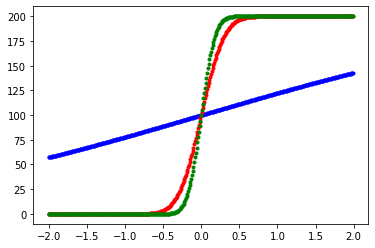

In [7]:
from scipy.special import erf
x=np.arange(-2, 2, 0.01)
y=erf(x)

H=100
plt.plot(x, H*(erf(0.2*x)+1), "b.")
plt.plot(x, H*(erf(3*x)+1), "r.")
plt.plot(x, H*(erf(5*x)+1), "g.")

# On Nike diagram
## Manipulate numax scatter

In [3]:
import scipy.spatial
from lib.histdist import model3, distfit, distance_to_edge # import distfit


In [5]:
### 1 observation
dist = np.load("sample/obs/nike_dist.npy")
bins = np.linspace(-0.5, 12, 1000)
hist_model = model3()
obj_obs = distfit(dist, bins, hist_model)
obj_obs.fit()
sharpness_obs = hist_model.sharpness(obj_obs.para_fit)
Nobs = dist.shape[0]

### 2 model
# manipulate models
numax_perturb = np.arange(0.00, 0.06, 0.001)
dnu_perturb = np.arange(0., 0.05, 0.1)
colors = sns.color_palette("Blues_d", numax_perturb.shape[0])
labels = ["{:0.0f}%".format(numax_perturb[i]*100) for i in range(numax_perturb.shape[0]) ]

# read in unperturbed dnu and numax, with edges
nike_samples = np.load("sample/padova/nike_samples.npy")
dnu, numax = nike_samples[:,0]**0.75/nike_samples[:,1], nike_samples[:,0]
nike_edges = np.load("sample/padova/nike_edge_samples.npy")
xedge, yedge = nike_edges[:,0], nike_edges[:,1]
tck_padova = np.load("sample/padova/spline_tck.npy", allow_pickle=True)
# metric = np.zeros((dnu_perturb.shape[0], numax_perturb.shape[0]))

for inumax in range(numax_perturb.shape[0]):
    for idnu in range(dnu_perturb.shape[0]):

        # initiate a plot
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)

        obj_obs.plot_hist(ax=ax, histkwargs={"color":"red", "label":"Observations", "zorder":100})
        obj_obs.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Observations fit", "linestyle":"--", "zorder":100})

        Ndata = numax.shape[0]
        fnumax = (np.random.randn(Ndata) * numax_perturb[inumax] + 1)
        fdnu = (np.random.randn(Ndata) * dnu_perturb[idnu] + 1)
        xdata, ydata = (numax*fnumax), (numax*fnumax)**0.75/(dnu*fdnu)
        
        dist = distance_to_edge(xdata, ydata, xedge, yedge, tck_padova)
        obj = distfit(dist, bins, hist_model)
        # obj.histy = obj.histy/(Ndata/Nobs)
        obj.fit()
        obj.plot_hist(ax=ax, histkwargs={"color":"blue", "label":"Galaxia"})
        obj.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Galaxia fit"})
        ax.set_title("Perturbations on numax: {:0.2f}%".format(numax_perturb[inumax]*100))
        
        sharpness_pdv = hist_model.sharpness(obj.para_fit)
        ax.text(0.9, 0.6, "Galaxia slope: {:0.1f}".format(sharpness_pdv), ha="right", va="top", transform=ax.transAxes)
        ax.text(0.9, 0.55, "Observational slope: {:0.1f}".format(sharpness_obs), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.45, "Galaxia slope (inflection): {:0.1f}".format(metric_model[1]), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.40, "Observational slope (inflection): {:0.1f}".format(metric_obs[1]), ha="right", va="top", transform=ax.transAxes)

        ax.legend()
        ax.set_xlim(-0.5,1.5)
        ax.grid("both")
        ax.set_ylim(-10, 410)

        plt.savefig("sample/sharpness/perturb_gif/{:0.0f}.png".format(inumax))
        plt.close()

In [7]:
Ndata, Nobs

(8821, 7434)

## numax horizontal scatter on nike diagram

In [17]:
### 1 observation
# read in unperturbed dnu and numax, with edges
nike_samples = np.load("sample/obs/nike_samples.npy")
xobs, yobs = nike_samples[:,0], nike_samples[:,1]
idx = (yobs>=3.0) & (yobs<=3.5)
xobs, yobs = xobs[idx], yobs[idx]

nike_edges = np.load("sample/obs/nike_edge_samples.npy")
xedge, yedge = nike_edges[:,0], nike_edges[:,1]
idx = (yedge>=3.0) & (yedge<=3.5)
xedge, yedge = xedge[idx], yedge[idx]
tck_obs = np.load("sample/obs/spline_tck.npy", allow_pickle=True)


hdist_obs = distance_to_edge(xobs, yobs, xedge, yedge, tck_obs, diagram="nike", distance="horizontal")
bins = np.linspace(-5, 20, 100)
hist_model = model3()
hist_model.prior_guess = [[-1., 3.], #xc
                            [1e-6, 100.], # s
                            [1e-6, 600.], #H
                            [1., 8.0], # x0
                            [1e-6, 3.], #tau
                            [5.0, 15.0], # x1
                            [-10, -1e-10]] #k
hist_model.para_guess = [0.1, 5., 500., 0.1, 0.5, 10., -1]
obj_obs = distfit(hdist_obs, bins, hist_model)
obj_obs.fit()
sharpness_obs = hist_model.sharpness(obj_obs.para_fit)
Nobs = hdist_obs.shape[0]


### 2 model
# manipulate models
numax_perturb = np.arange(0.00, 0.06, 0.001)
dnu_perturb = np.arange(0., 0.05, 0.1)
colors = sns.color_palette("Blues_d", numax_perturb.shape[0])
labels = ["{:0.0f}%".format(numax_perturb[i]*100) for i in range(numax_perturb.shape[0]) ]

# read in unperturbed dnu and numax, with edges
nike_samples = np.load("sample/padova/nike_samples.npy")
dnu, numax = nike_samples[:,0]**0.75/nike_samples[:,1], nike_samples[:,0]
idx = (numax**0.75/dnu>=3.0) & (numax**0.75/dnu<=3.5)
dnu, numax = dnu[idx], numax[idx]
nike_edges = np.load("sample/padova/nike_edge_samples.npy")
xedge, yedge = nike_edges[:,0], nike_edges[:,1]
tck_padova = np.load("sample/padova/spline_tck.npy", allow_pickle=True)

# metric = np.zeros((dnu_perturb.shape[0], numax_perturb.shape[0]))

for inumax in range(numax_perturb.shape[0]):
    for idnu in range(dnu_perturb.shape[0]):

        # initiate a plot
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)

        obj_obs.plot_hist(ax=ax, histkwargs={"color":"red", "label":"Observations", "zorder":100})
        obj_obs.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Observations fit", "linestyle":"--", "zorder":100})

        Ndata = numax.shape[0]
        fnumax = (np.random.randn(Ndata) * numax_perturb[inumax] + 1)
        fdnu = (np.random.randn(Ndata) * dnu_perturb[idnu] + 1)
        xdata, ydata = (numax*fnumax), (numax*fnumax)**0.75/(dnu*fdnu)
        
        dist = distance_to_edge(xdata, ydata, xedge, yedge, tck_padova, diagram="nike", distance="horizontal")
        obj = distfit(dist, bins, hist_model)
        # obj.histy = obj.histy/(Ndata/Nobs)
        obj.fit()
        obj.plot_hist(ax=ax, histkwargs={"color":"blue", "label":"Galaxia"})
        obj.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Galaxia fit"})
        ax.set_title("Perturbations on numax: {:0.2f}%".format(numax_perturb[inumax]*100))
        
        sharpness_pdv = hist_model.sharpness(obj.para_fit)
        ax.text(0.9, 0.6, "Galaxia slope: {:0.1f}".format(sharpness_pdv), ha="right", va="top", transform=ax.transAxes)
        ax.text(0.9, 0.55, "Observational slope: {:0.1f}".format(sharpness_obs), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.45, "Galaxia slope (inflection): {:0.1f}".format(metric_model[1]), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.40, "Observational slope (inflection): {:0.1f}".format(metric_obs[1]), ha="right", va="top", transform=ax.transAxes)

        ax.legend()
        ax.set_xlim(obj_obs.histx.min()-(obj_obs.histx.max()-obj_obs.histx.min())*0.2, obj_obs.histx.max())
        ax.grid(True)
        ax.set_ylim(-10., obj_obs.histy.max()*1.5)

        plt.savefig("sample/sharpness/perturb_gif_nike/numax_horizontal/{:0.0f}_numax.png".format(inumax))
        plt.close()

## Simultaneously manipulate the accuracy of dnu and numax.

In [10]:
# initiate a plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

### 1 observation
dist = np.load("sample/obs/nike_dist.npy")
bins = np.linspace(-5, 30, 50)
obj_obs = distfit(dist, bins, model1())
# obj_obs.plot_hist(ax=ax, histkwargs={"color":"red", "label":"Observations", "zorder":100})
obj_obs.fit()
# obj_obs.plot_fit(ax=ax, fitkwargs={"color":"red", "label":"Observations", "zorder":100})
metric_obs = model1_metric(obj_obs.para_fit, obj_obs.histx, obj_obs.histy)
print("Observations", "{:0.5f}".format(metric_obs[0]))


### 2 model
# manipulate models
numax_perturb = np.arange(0., 0.1, 0.01)
dnu_perturb = np.arange(0., 0.1, 0.01)
# colors = sns.color_palette("Blues_d", numax_perturb.shape[0])
# labels = ["{:0.0f}%".format(numax_perturb[i]*100) for i in range(numax_perturb.shape[0]) ]

# read in unperturbed dnu and numax, with edges
nike_samples = np.load("sample/padova/nike_samples.npy")
dnu, numax = nike_samples[:,0]**0.75/nike_samples[:,1], nike_samples[:,0]
nike_edges = np.load("sample/padova/nike_edge_samples.npy")
xedge, yedge = nike_edges[:,0], nike_edges[:,1]
tck_padova = np.load("sample/padova/spline_tck.npy", allow_pickle=True)
metric = np.zeros((dnu_perturb.shape[0], numax_perturb.shape[0]))

for inumax in range(numax_perturb.shape[0]):
    for idnu in range(dnu_perturb.shape[0]):
        Ndata = numax.shape[0]
        fnumax = (np.random.randn(Ndata) * numax_perturb[inumax] + 1)
        fdnu = (np.random.randn(Ndata) * dnu_perturb[idnu] + 1)
        xdata, ydata = (numax*fnumax), (numax*fnumax)**0.75/(dnu*fdnu)
        
        dist = shortest_distance_nike(xdata, ydata, xedge, yedge, tck_padova)
        obj = distfit(dist, bins, model1())
        obj.fit()
        # obj.plot_fit(ax=ax, fitkwargs={"color":colors[inumax], "label":labels[inumax]})
        metric_mod = model1_metric(obj.para_fit, obj.histx, obj.histy)
        print(numax_perturb[inumax], dnu_perturb[idnu], "{:0.5f}".format(metric_mod[0]))
        metric[idnu, inumax] = metric_mod[0]

# ax.legend()
# ax.set_xlim(-0.5,2)

data = [metric_obs[0], metric, dnu_perturb, numax_perturb]
np.save("sample/sharpness/metric", data)

NameError: name 'model1' is not defined

Text(0, 0.5, 'Fractional perturbation on dnu [%]')

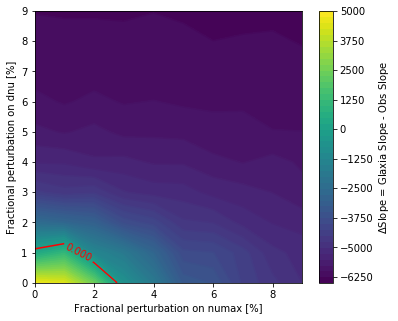

In [70]:
metric_obs, metric, dnu_perturb, numax_perturb = np.load("sample/sharpness/metric.npy", allow_pickle=True)
metric_obs = 1.0/metric_obs
metric = 1.0/metric

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
cl=ax.contour(numax_perturb*100, dnu_perturb*100, metric-metric_obs, levels=50)
idx = np.where(np.abs(cl.levels - 0.) == np.min(np.abs(cl.levels - 0.)) )[0][0]
cl.collections[idx].set_color("red")
ax.clabel(cl, [cl.levels[idx]], colors="red")
c=ax.contourf(numax_perturb*100, dnu_perturb*100, metric-metric_obs, levels=50)
cbar = plt.colorbar(c)
cbar.set_label('$\Delta$Slope = Glaxia Slope - Obs Slope')#, rotation=270)
ax.set_xlabel("Fractional perturbation on numax [%]")
ax.set_ylabel("Fractional perturbation on dnu [%]")
# plt.contour(numax_perturb, dnu_perturb, metric-metric_obs, levels=100)

In [64]:
idx

array([26], dtype=int64)

# Dnu-numax diagram
## First focus on numax- horizontal distance

In [12]:
### 1 observation
# read in unperturbed dnu and numax, with edges
tnu_samples = np.load("sample/obs/tnu_samples.npy")
numax_obs, dnu_obs = tnu_samples[:,0], tnu_samples[:,1]
idx = dnu_obs>4.5
numax_obs, dnu_obs = numax_obs[idx], dnu_obs[idx]

tnu_edges = np.load("sample/obs/tnu_edge_samples.npy")
xedge, yedge = tnu_edges[:,0], tnu_edges[:,1]
tck_obs = np.load("sample/obs/spline_tck.npy", allow_pickle=True)


hdist_obs = distance_to_edge(numax_obs, dnu_obs, xedge, yedge, tck_obs, diagram="tnu", distance="horizontal")
bins = np.linspace(-5, 20, 200)
hist_model = model3()
hist_model.prior_guess = [[-1., 3.], #xc
                            [1e-6, 100.], # s
                            [1e-6, 100.], #H
                            [1., 5.0], # x0
                            [1e-6, 3.], #tau
                            [5.0, 15.0], # x1
                            [-10, -1e-10]] #k
hist_model.para_guess = [0.1, 5., 50., 0.1, 0.5, 10., -1]
obj_obs = distfit(hdist_obs, bins, hist_model)
obj_obs.fit()
sharpness_obs = hist_model.sharpness(obj_obs.para_fit)
Nobs = hdist_obs.shape[0]


### 2 model
# manipulate models
numax_perturb = np.arange(0.00, 0.06, 0.001)
dnu_perturb = np.arange(0., 0.05, 0.1)
colors = sns.color_palette("Blues_d", numax_perturb.shape[0])
labels = ["{:0.0f}%".format(numax_perturb[i]*100) for i in range(numax_perturb.shape[0]) ]

# read in unperturbed dnu and numax, with edges
tnu_samples = np.load("sample/padova/tnu_samples.npy")
numax, dnu = tnu_samples[:,0], tnu_samples[:,1]
idx = dnu>4.5
numax, dnu = numax[idx], dnu[idx]
tnu_edges = np.load("sample/padova/tnu_edge_samples.npy")
xedge, yedge = tnu_edges[:,0], tnu_edges[:,1]
tck_padova = np.load("sample/padova/spline_tck.npy", allow_pickle=True)
# metric = np.zeros((dnu_perturb.shape[0], numax_perturb.shape[0]))

for inumax in range(numax_perturb.shape[0]):
    for idnu in range(dnu_perturb.shape[0]):

        # initiate a plot
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)

        obj_obs.plot_hist(ax=ax, histkwargs={"color":"red", "label":"Observations", "zorder":100})
        obj_obs.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Observations fit", "linestyle":"--", "zorder":100})

        Ndata = numax.shape[0]
        fnumax = (np.random.randn(Ndata) * numax_perturb[inumax] + 1)
        fdnu = (np.random.randn(Ndata) * dnu_perturb[idnu] + 1)
        xdata, ydata = (numax*fnumax), (dnu*fdnu)
        
        dist = distance_to_edge(xdata, ydata, xedge, yedge, tck_padova, diagram="tnu", distance="horizontal")
        obj = distfit(dist, bins, hist_model)
        # obj.histy = obj.histy/(Ndata/Nobs)
        obj.fit()
        obj.plot_hist(ax=ax, histkwargs={"color":"blue", "label":"Galaxia"})
        obj.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Galaxia fit"})
        ax.set_title("Perturbations on numax: {:0.2f}%".format(numax_perturb[inumax]*100))
        
        sharpness_pdv = hist_model.sharpness(obj.para_fit)
        ax.text(0.9, 0.6, "Galaxia slope: {:0.1f}".format(sharpness_pdv), ha="right", va="top", transform=ax.transAxes)
        ax.text(0.9, 0.55, "Observational slope: {:0.1f}".format(sharpness_obs), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.45, "Galaxia slope (inflection): {:0.1f}".format(metric_model[1]), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.40, "Observational slope (inflection): {:0.1f}".format(metric_obs[1]), ha="right", va="top", transform=ax.transAxes)

        ax.legend()
        ax.set_xlim(obj_obs.histx.min()-(obj_obs.histx.max()-obj_obs.histx.min())*0.2, obj_obs.histx.max())
        ax.grid(True)
        ax.set_ylim(-10., obj_obs.histy.max()*1.5)

        plt.savefig("sample/sharpness/perturb_gif_tnu/numax/{:0.0f}_numax.png".format(inumax))
        plt.close()

/Users/yaguang/Dropbox (Sydney Uni)/Work/nike/lib/histdist.py:115: RuntimeWarning: divide by zero encountered in double_scalars
  A = H/(erf(s*(x0-xc))+1)
/Users/yaguang/Dropbox (Sydney Uni)/Work/nike/lib/histdist.py:116: RuntimeWarning: invalid value encountered in multiply
  ymodel[idx] = A*(erf(s*(x[idx]-xc))+1)


In [6]:
tnu_edges

4.23628578],
       [  4.23601461],
       [  4.23574819],
       [  4.23548641],
       [  4.23522921],
       [  4.23497648],
       [  4.23472815],
       [  4.23448413],
       [  4.23424432],
       [  4.23400866],
       [  4.23377705],
       [  4.2335494 ],
       [  4.23332564],
       [  4.23310567],
       [  4.23288942],
       [  4.23267679],
       [  4.23246771],
       [  4.23226209],
       [  4.23205984],
       [  4.23186089],
       [  4.23166514],
       [  4.23147252],
       [  4.23128295],
       [  4.23109633],
       [  4.23091259],
       [  4.23073165],
       [  4.23055341],
       [  4.23037781],
       [  4.23020476],
       [  4.23003417],
       [  4.22986596],
       [  4.22970006],
       [  4.22953638],
       [  4.22937484],
       [  4.22921536],
       [  4.22905786],
       [  4.22890225],
       [  4.22874846],
       [  4.22859641],
       [  4.22844602],
       [  4.2282972 ],
       [  4.22814988],
       [  4.22800397],
       [  4.2278594 ]

## Second focus on dnu - vertical distance

In [5]:
### 1 observation
# read in unperturbed dnu and numax, with edges
tnu_samples = np.load("sample/obs/tnu_samples.npy")
numax_obs, dnu_obs = tnu_samples[:,0], tnu_samples[:,1]
tnu_edges = np.load("sample/obs/tnu_edge_samples.npy")
xedge, yedge = tnu_edges[:,0], tnu_edges[:,1]
tck_obs = np.load("sample/obs/spline_tck.npy", allow_pickle=True)


hdist_obs = distance_to_edge(numax_obs, dnu_obs, xedge, yedge, tck_obs, diagram="tnu", distance="vertical")
bins = np.linspace(-0.5, 3, 200)
hist_model = model3()
hist_model.prior_guess = [[-0.5, 0.3], #xc
                            [1e-6, 100.], # s
                            [1e-6, 500.], #H
                            [0.1, 0.5], # x0
                            [1e-6, 10.], #tau
                            [0.5, 5.0], # x1
                            [-10, -1e-10]] #k
hist_model.para_guess = [0.1, 5., 300., 0.3, 0.5, 3., -1]
obj_obs = distfit(hdist_obs, bins, hist_model)
obj_obs.fit()
sharpness_obs = hist_model.sharpness(obj_obs.para_fit)
Nobs = hdist_obs.shape[0]


### 2 model
# manipulate models
numax_perturb = np.arange(0.00, 0.06, 0.1)
dnu_perturb = np.arange(0., 0.05, 0.001)
colors = sns.color_palette("Blues_d", numax_perturb.shape[0])
labels = ["{:0.0f}%".format(numax_perturb[i]*100) for i in range(numax_perturb.shape[0]) ]

# read in unperturbed dnu and numax, with edges
tnu_samples = np.load("sample/padova/tnu_samples.npy")
numax, dnu = tnu_samples[:,0], tnu_samples[:,1]
tnu_edges = np.load("sample/padova/tnu_edge_samples.npy")
xedge, yedge = tnu_edges[:,0], tnu_edges[:,1]
tck_padova = np.load("sample/padova/spline_tck.npy", allow_pickle=True)
# metric = np.zeros((dnu_perturb.shape[0], numax_perturb.shape[0]))

for inumax in range(numax_perturb.shape[0]):
    for idnu in range(dnu_perturb.shape[0]):

        # initiate a plot
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)

        obj_obs.plot_hist(ax=ax, histkwargs={"color":"red", "label":"Observations", "zorder":100})
        obj_obs.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Observations fit", "linestyle":"--", "zorder":100})

        Ndata = numax.shape[0]
        fnumax = (np.random.randn(Ndata) * numax_perturb[inumax] + 1)
        fdnu = (np.random.randn(Ndata) * dnu_perturb[idnu] + 1)
        xdata, ydata = (numax*fnumax), (dnu*fdnu)
        
        dist = distance_to_edge(xdata, ydata, xedge, yedge, tck_padova, diagram="tnu", distance="vertical")
        obj = distfit(dist, bins, hist_model)
        # obj.histy = obj.histy/(Ndata/Nobs)
        obj.fit()
        obj.plot_hist(ax=ax, histkwargs={"color":"blue", "label":"Galaxia"})
        obj.plot_fit(ax=ax, fitkwargs={"color":"black", "label":"Galaxia fit"})
        ax.set_title("Perturbations on dnu: {:0.2f}%".format(dnu_perturb[idnu]*100))
        
        sharpness_pdv = hist_model.sharpness(obj.para_fit)
        ax.text(0.9, 0.6, "Galaxia slope: {:0.1f}".format(sharpness_pdv), ha="right", va="top", transform=ax.transAxes)
        ax.text(0.9, 0.55, "Observational slope: {:0.1f}".format(sharpness_obs), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.45, "Galaxia slope (inflection): {:0.1f}".format(metric_model[1]), ha="right", va="top", transform=ax.transAxes)
        # ax.text(0.9, 0.40, "Observational slope (inflection): {:0.1f}".format(metric_obs[1]), ha="right", va="top", transform=ax.transAxes)

        ax.legend()
        ax.set_xlim(obj_obs.histx.min()-(obj_obs.histx.max()-obj_obs.histx.min())*0.2, obj_obs.histx.max())
        ax.grid(True)
        ax.set_ylim(-10., obj_obs.histy.max()*1.5)

        plt.savefig("sample/sharpness/perturb_gif_tnu/dnu/{:0.0f}_dnu.png".format(idnu))
        plt.close()

c:\Users\yali4742\Dropbox (Sydney Uni)\Work\nike\lib\histdist.py:115: RuntimeWarning: divide by zero encountered in double_scalars
  A = H/(erf(s*(x0-xc))+1)
c:\Users\yali4742\Dropbox (Sydney Uni)\Work\nike\lib\histdist.py:116: RuntimeWarning: invalid value encountered in multiply
  ymodel[idx] = A*(erf(s*(x[idx]-xc))+1)
c:\Users\yali4742\Dropbox (Sydney Uni)\Work\nike\lib\histdist.py:114: RuntimeWarning: invalid value encountered in less
  idx = x<x0
c:\Users\yali4742\Dropbox (Sydney Uni)\Work\nike\lib\histdist.py:117: RuntimeWarning: invalid value encountered in greater_equal
  idx = (x>=x0) & (x<x1)
c:\Users\yali4742\Dropbox (Sydney Uni)\Work\nike\lib\histdist.py:117: RuntimeWarning: invalid value encountered in less
  idx = (x>=x0) & (x<x1)
c:\Users\yali4742\Dropbox (Sydney Uni)\Work\nike\lib\histdist.py:119: RuntimeWarning: invalid value encountered in greater_equal
  idx = x>=x1


# Metallicity effect?

In [16]:
import os
from astropy.io import ascii
yu = ascii.read("sample/yu+2018.csv")
idx = (yu["Phase"]==2) & (np.array(yu["numax"]**0.75/yu["Delnu"])>3.0)
yu = yu[idx]
feh_limits = np.percentile(yu["[Fe/H]"], [0., 33.3, 66.6, 100.])

feh_obs = np.array(yu["[Fe/H]"])

import ebf
synp=ebf.read("sample/kepler_galaxia_mrtd5.ebf")
Nstar = synp["alpha"].shape[0]
factor = int(Nstar/16000)
idx = np.arange(0,int(Nstar/factor))*factor
for key in synp.keys():
    synp[key] = synp[key][idx]
idx = (synp["evstate"]==2) & (np.isfinite(synp["numax"])) & (np.array(synp["numax"]**0.75/synp["dnu"])>3.0)
xpdv, ypdv, ypdvt = synp["numax"][idx], synp["numax"][idx]**0.75/synp["dnu"][idx], synp["dnu"][idx]
Npdv = xpdv.shape[0]
feh_pdv = synp["feh"][idx]


for ifeh in range(feh_limits.shape[0]-1):
    
    ### 1 observation
    dist = np.load("sample/obs/nike_dist.npy")
    bins = np.linspace(-0.5, 12, 1000)
    idx = (feh_obs>=feh_limits[ifeh]) & (feh_obs<=feh_limits[ifeh+1])
    obj_obs = distfit(dist[idx], bins, model1())
    obj_obs.fit()
    metric_obs = model1_metric(obj_obs.para_fit, obj_obs.histx, obj_obs.histy)


    ### 2 model
    # manipulate models
    numax_perturb = np.arange(0., 0.1, 0.01)
    dnu_perturb = np.arange(0., 0.1, 0.01)
    # colors = sns.color_palette("Blues_d", numax_perturb.shape[0])
    # labels = ["{:0.0f}%".format(numax_perturb[i]*100) for i in range(numax_perturb.shape[0]) ]

    # read in unperturbed dnu and numax, with edges
    idx = (feh_pdv>=feh_limits[ifeh]) & (feh_pdv<=feh_limits[ifeh+1])
    nike_samples = np.load("sample/padova/nike_samples.npy")[idx,:]
    dnu, numax = nike_samples[:,0]**0.75/nike_samples[:,1], nike_samples[:,0]
    nike_edges = np.load("sample/padova/nike_edge_samples.npy")
    xedge, yedge = nike_edges[:,0], nike_edges[:,1]
    tck_padova = np.load("sample/padova/spline_tck.npy", allow_pickle=True)
    metric = np.zeros((dnu_perturb.shape[0], numax_perturb.shape[0]))

    for inumax in range(numax_perturb.shape[0]):
        for idnu in range(dnu_perturb.shape[0]):
            Ndata = numax.shape[0]
            fnumax = (np.random.randn(Ndata) * numax_perturb[inumax] + 1)
            fdnu = (np.random.randn(Ndata) * dnu_perturb[idnu] + 1)
            xdata, ydata = (numax*fnumax), (numax*fnumax)**0.75/(dnu*fdnu)
            
            dist = shortest_distance_nike(xdata, ydata, xedge, yedge, tck_padova)
            obj = distfit(dist, bins, model1())
            obj.fit()
            metric_mod = model1_metric(obj.para_fit, obj.histx, obj.histy)
            print(numax_perturb[inumax], dnu_perturb[idnu], "{:0.5f}".format(metric_mod[0]))
            metric[idnu, inumax] = metric_mod[0]

    data = [metric_obs[0], metric, dnu_perturb, numax_perturb]
    filepath="sample/sharpness/metallicity/{:0.0f}/".format(ifeh)
    if not os.path.exists(filepath): os.mkdir(filepath)
    np.save(filepath+"metric", data)

C:\Users\yali4742\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
0.0 0.0 2371.36071
0.0 0.01 864.99767
0.0 0.02 415.78938
0.0 0.03 226.79402
0.0 0.04 155.41364
0.0 0.05 154.75504
0.0 0.06 68.63410
0.0 0.07 60.30164
0.0 0.08 36.33624
0.0 0.09 21.69906
0.01 0.0 1690.50374
0.01 0.01 1204.54955
0.01 0.02 357.57627
0.01 0.03 227.53734
0.01 0.04 140.06544
0.01 0.05 111.60405
0.01 0.06 51.72895
0.01 0.07 54.97953
0.01 0.08 23.63948
0.01 0.09 63.98100
0.02 0.0 1993.21625
0.02 0.01 785.18384
0.02 0.02 321.78581
0.02 0.03 161.29168
0.02 0.04 177.66557
0.02 0.05 74.40531
0.02 0.06 84.16422
0.02 0.07 67.73919
0.02 0.08 25.70835
0.02 0.09 29.03674
0.03 0.0 1025.42419
0.03 0.01 633.57870
0.03 0.02 313.96546
0.03 0.03 182.49573
0.03 0.04 162.00879
0.03 0.05 106.19455
0.03 0.06 78.05593
0.03 0.07 47.90791
0.03 0.08 29.99999
0.03 0.09 33.51794
0.04 0.0 853.98760
0.04 0.01 567.49605
0.04 0.02 418.70473
0.04 0.03 244.4595

In [14]:
feh_limits

array([-2.44, -0.21,  0.02,  1.  ])

1. test for somthing inflection point
2. metallicity effect


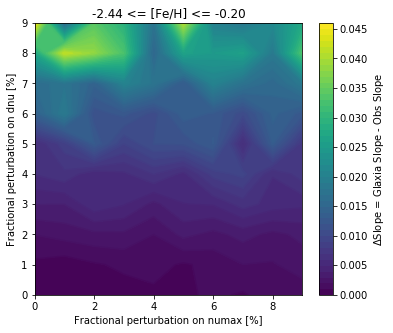

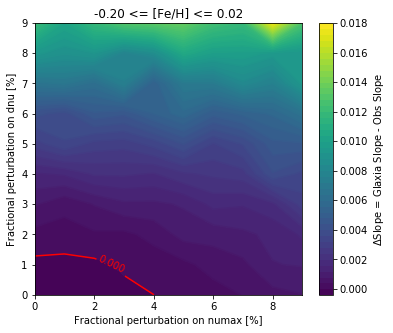

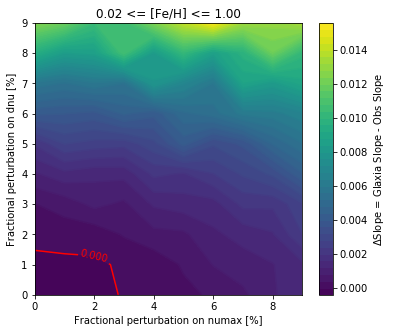

In [19]:
for ifeh in range(feh_limits.shape[0]-1):
    filepath="sample/sharpness/metallicity/{:0.0f}/".format(ifeh)
    metric_obs, metric, dnu_perturb, numax_perturb = np.load(filepath+"metric.npy", allow_pickle=True)
    metric_obs = 1.0/metric_obs
    metric = 1.0/metric

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    cl=ax.contour(numax_perturb*100, dnu_perturb*100, metric-metric_obs, levels=50)
    idx = np.where(np.abs(cl.levels - 0.) == np.min(np.abs(cl.levels - 0.)) )[0][0]
    cl.collections[idx].set_color("red")
    ax.clabel(cl, [cl.levels[idx]], colors="red")
    c=ax.contourf(numax_perturb*100, dnu_perturb*100, metric-metric_obs, levels=50)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta$Slope = Glaxia Slope - Obs Slope')#, rotation=270)
    ax.set_xlabel("Fractional perturbation on numax [%]")
    ax.set_ylabel("Fractional perturbation on dnu [%]")
    ax.set_title("{:0.2f} <= [Fe/H] <= {:0.2f}".format(feh_limits[ifeh], feh_limits[ifeh+1]))
    # plt.contour(numax_perturb, dnu_perturb, metric-metric_obs, levels=100)

In [20]:
yu[""]

KIC,Kpmag,QLen,DLen,numax,Delnu,A,Width,Gran,Teff,log(g),[Fe/H],NoCorM,NoCorR,RGBcorM,RGBcorR,ClcorM,ClcorR,Phase,M17,Simbad,_RA,_DE,2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD,angDist
int32,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,str3,str6,float64,float64,str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,int32,int32,float64,float64
892760,13.23,6,380.8,29.48,3.962,149.7,12.0,6319.1,5188,2.394,-0.21,1.0,10.51,1.04,10.74,1.0,10.52,2,M17,Simbad,291.15103,36.68494,19243624+3641057,291.151017,36.684937,0.07,0.06,0.0,11.509,10.959,10.863,0.02,0.019,0.018,AAA,222,0,2450959.9709,0.039053
1026084,12.14,15,1139.0,41.17,4.414,63.8,24.8,733.1,5072,2.534,-0.12,1.71,11.69,1.67,11.55,1.75,11.83,2,M17,Simbad,291.05618,36.7040411,19241348+3642145,291.056199,36.704044,0.06,0.06,0.0,10.408,9.856,9.739,0.021,0.021,0.017,AAA,222,0,2450959.9709,0.055823
1026180,11.74,4,206.3,36.91,3.991,116.1,14.0,1641.2,4718,2.471,-0.02,1.65,12.37,1.5,11.8,1.67,12.43,2,M17,Simbad,291.08017,36.7605019,19241923+3645378,291.080153,36.760502,0.06,0.06,0.0,9.851,9.265,9.127,0.021,0.021,0.018,AAA,222,0,2450959.9709,0.049031
1026452,12.94,18,1318.1,34.5,3.967,83.3,13.6,1692.1,5089,2.458,-0.11,1.55,12.15,1.53,12.08,1.58,12.27,2,M17,Simbad,291.14383,36.7901311,19243452+3647244,291.143834,36.790131,0.06,0.06,0.0,11.272,10.742,10.637,0.021,0.021,0.017,AAA,222,0,2450959.9709,0.011538
1160684,14.91,17,1308.7,26.38,3.361,121.1,20.9,1184.2,4128,2.296,-0.09,0.98,11.66,0.82,10.66,0.95,11.47,2,M17,Simbad,290.85275,36.86916,19232466+3652089,290.852754,36.869156,0.06,0.06,0.0,12.687,12.028,11.861,0.022,0.022,0.02,AAA,222,0,2450959.9612,0.018441
1160789,9.7,18,1318.1,24.72,3.509,149.0,11.1,9115.0,4724,2.297,-0.27,0.83,10.72,0.74,10.14,0.83,10.7,2,M17,Simbad,290.88666,36.8724289,19233280+3652207,290.886667,36.872429,0.06,0.06,90.0,8.133,7.593,7.497,0.021,0.021,0.017,AAA,111,0,2450959.963,0.020163
1161447,12.61,7,467.3,36.18,4.125,100.3,15.5,3105.1,4793,2.466,0.07,1.4,11.44,1.31,11.07,1.41,11.52,2,M17,Simbad,291.07278,36.8628011,19241746+3651460,291.072778,36.862801,0.06,0.06,0.0,10.865,10.28,10.174,0.021,0.019,0.017,AAA,222,0,2450959.9708,0.005772
1161618,10.22,18,1318.1,34.32,4.108,121.7,14.4,2954.8,4747,2.441,0.08,1.19,10.89,1.11,10.52,1.2,10.92,2,M17,Simbad,291.10892,36.81329,19242614+3648478,291.108918,36.813293,0.06,0.06,0.0,8.542,7.974,7.887,0.018,0.026,0.018,AAA,111,0,2450959.9708,0.012242
1162746,11.45,18,1318.1,27.38,3.703,140.5,12.3,6804.2,4989,2.354,-0.56,0.99,10.96,0.93,10.64,1.01,11.07,2,M17,Simbad,291.35999,36.8198889,19252639+3649116,291.359984,36.819893,0.06,0.06,0.0,9.834,9.272,9.183,0.022,0.02,0.018,AAA,222,0,2450965.8194,0.022734
